### Libraries

In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
from sklearn.metrics import roc_auc_score
import math
%matplotlib inline

### Read data

In [2]:
filename = './data/prepr_train.csv'
train_data_ = pd.read_csv(filename)
print ('Data size:', len(train_data_))
train_data_.head()

Data size: 3947


,Insult,Date,Comment
0,1,20120618192155Z,you fuck your dad
1,0,20120528192215Z,i really do not understand your point xa it se...
2,0,NaN,a xc xa majority of canadians can and has been...
3,0,NaN,listen if you dont wanna get married to a man ...
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...


In [3]:
filename = './data/prepr_valid.csv'
valid_data_ = pd.read_csv(filename)
print ('Data size:', len(valid_data_))
valid_data_.head()

Data size: 2647


,Insult,Date,Comment,Usage
0,0,NaN,the drudge report n n n nyou wo not see this s...,PublicTest
1,0,20120618222256Z,ian xa roger clemens is the fucking man and ne...,PublicTest
2,1,20120618213617Z,agree with alan you are an extremest idiot you...,PublicTest
3,0,NaN,really <SIGNS> n ni see marc lamont hill on va...,PrivateTest
4,0,20120620003825Z,really suck is not the word when many of our n...,PrivateTest


In [4]:
filename = './data/prepr_test.csv'
test_data_ = pd.read_csv(filename)
print ('Data size:', len(test_data_))
test_data_.head()

Data size: 2235


,Insult,Date,Comment
0,0,20120603163526Z,like this if you are a tribe fan
1,1,20120531215447Z,you idiot
2,1,20120823164228Z,i am a woman babs and the only war on women i ...
3,1,20120826010752Z,wow you benefitted so many wins this year from...
4,1,20120602223825Z,haha green me red you now loser whos winning n...


In [5]:
train_data = train_data_
valid_data = valid_data_
test_data = test_data_

valid_size = len(valid_data)
train_size = len(train_data)
test_size = len(test_data)

X_train = train_data['Comment']
y_train = train_data['Insult']
X_valid = valid_data['Comment']
y_valid = valid_data['Insult']
X_test = test_data['Comment']
y_test = test_data['Insult']

### Compose vocabulary

In [9]:
vocabulary_size = 100000

def build_vocabulary(words):
    counter_words = collections.Counter(words)
    count = [['UNK', -3], ['<EOS>', 0], ['<PAD>', 0], ['<SIGNS>', counter_words['<SIGNS>']]]
    count.extend(counter_words.most_common(vocabulary_size - 4))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

words = ' '.join(X_train)
print ('Length of train data in words:', len(words))

data, count, dictionary, reverse_dictionary = build_vocabulary(words.split(' '))
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

print ('Dict:', dictionary['UNK'])
print ('Reverse dict:', reverse_dictionary[0])
print ('Counter:', count[dictionary['UNK']])
print ('Data:', data[0])
print ('Words:', words[:10])
del words

Length of train data in words: 728927
Most common words (+UNK) [['UNK', 0], ['<EOS>', 0], ['<PAD>', 0], ['<SIGNS>', 1747], ('the', 4780)]
Sample data [5, 74, 19, 691, 10, 98, 23, 13, 255, 19]
Dict: 0
Reverse dict: UNK
Counter: ['UNK', 0]
Data: 5
Words: you fuck y


### Word indexing

In [10]:
def word2id(word):
    if word in dictionary:
        return dictionary[word]
    else:
        return 0 # UNK

def id2word(id_):
    return reverse_dictionary[id_]


def comment2vec(comment):
    global comment_size
    split = comment.split(' ')
    res = np.array([word2id(word) for word in split], dtype='int')
    return res

def vec2comment(vec):
    global comment_size
    return ' '.join([id2word(id_) for id_ in vec])


### Generation of batches

In [11]:
class LabeledBatchGenerator(object):
    def __init__(self, comments, batch_size, comment_size, labels):
        self._comments = comments
        self._num_comments = len(comments)
        self._batch_size = batch_size
        self._comment_size = comment_size
        self._labels = labels
        segment = self._num_comments // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        
    def _next_batch(self, step):
        batch = np.zeros(shape=(self._batch_size,1), dtype=np.int)
        for b in range(self._batch_size):
            comment = comment2vec(self._comments[self._cursor[b]])
            N = len(comment)
            if step < N:
                batch[b,0] = comment[step]
            elif step == N:
                batch[b,0] = word2id('<EOS>')
            elif step > N:
                batch[b,0] = word2id('<PAD>')
            if step == self._comment_size - 1:
                if N > self._comment_size - 1:
                    batch[b,0] = word2id('<EOS>')
                self._cursor[b] = (self._cursor[b] + 1) % self._num_comments
        return batch
    
    def next(self):
        batches = []
        batches_labels = [self._labels[self._cursor[b]] for b in range(self._batch_size)]
        for step in range(0, self._comment_size):
            batches.append(self._next_batch(step))
        return batches, batches_labels

In [12]:
comment_size = 100
batch_size = 64
valid_batch_size = valid_size
test_batch_size = test_size

train_batch_generator = LabeledBatchGenerator(X_train.as_matrix(), batch_size, comment_size, y_train.as_matrix())
valid_batch_generator = LabeledBatchGenerator(X_valid.as_matrix(), valid_batch_size, comment_size, y_valid.as_matrix())
test_batch_generator = LabeledBatchGenerator(X_test.as_matrix(), test_batch_size, comment_size, y_test.as_matrix())

In [13]:
def plot_results(losses_, mean_losses_, train_aucs_, valid_aucs_, frequency):
    plt.plot(losses_)
    plt.title('Losses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(frequency * np.arange(1,len(mean_losses_)+1), mean_losses_)
    plt.title('MeanLosses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(train_aucs_, label='Train AUC-ROC')
    plt.plot(frequency * np.arange(1,len(valid_aucs_)+1), valid_aucs_, label='Valid AUC-ROC')
    plt.xlabel('Step')
    plt.title('AUC-ROC')
    plt.legend()
    plt.show()

### Tensorflow graph

In [63]:
embedding_size = 128
patch_size = [3,3,3]
num_filters = 128

graph = tf.Graph()
with graph.as_default():
    tf_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embed', trainable=False)
    tf_keep_prob = tf.placeholder(tf.float32)
    tf_data = list()
    tf_labels = tf.placeholder(tf.float32, shape=[None,1])
    for _ in range(comment_size):
        tf_data.append(tf.placeholder(tf.int32, shape=[None, 1]))  
    tf_inputs = tf.concat(tf_data[:comment_size], axis=1)    
    tf_embedded_inputs = tf.nn.embedding_lookup(tf_embeddings, tf_inputs) # batch_size, comment_size, embed_size

    tf_w0 = tf.Variable(tf.truncated_normal(
            [patch_size[0], embedding_size, num_filters], stddev=0.1), name='w0')
    tf_w1 = tf.Variable(tf.truncated_normal(
            [patch_size[1], embedding_size, num_filters], stddev=0.1), name='w1')
    tf_w2 = tf.Variable(tf.truncated_normal(
            [patch_size[2], embedding_size, num_filters], stddev=0.1), name='w2')
    
    def multi_layer_cnn(data):
        output = []
        conv = tf.nn.conv1d(data, tf_w0, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, 2, 2, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        conv = tf.nn.conv1d(data, tf_w1, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, 2, 2, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        conv = tf.nn.conv1d(data, tf_w2, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, 2, 2, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        output = tf.concat(output, axis=2)
        print (output.shape)
        
        shape = output.get_shape().as_list()
        reshape = tf.reshape(output, [-1, shape[1] * shape[2]])
        return tf.layers.dense(inputs=reshape, units=1, activation=None, kernel_regularizer=tf.nn.l2_loss)

    tf_logits = tf.nn.dropout(multi_layer_cnn(tf_embedded_inputs), tf_keep_prob)
    tf_logits = multi_layer_cnn(tf_embedded_inputs)
    print ('logits shape:', tf_logits)
    tf_loss = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf_logits, labels=tf_labels))
              + 0.01 * tf.nn.l2_loss(tf_w0) + 0.01 * tf.nn.l2_loss(tf_w1) + 0.01 * tf.nn.l2_loss(tf_w2))
    tf_global_step = tf.Variable(0, trainable=False, name='step')
    tf_learning_rate = tf.train.exponential_decay(0.01, tf_global_step,
                                               1000, 0.9, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.minimize(loss, global_step=global_step)
    tf_optimizer = tf.train.AdamOptimizer(tf_learning_rate)
    tf_grads = tf_optimizer.compute_gradients(tf_loss)
    tf_op = tf_optimizer.apply_gradients(tf_grads, global_step=tf_global_step)

    tf_prediction = tf.round(tf.sigmoid(tf_logits))

    saver = tf.train.Saver()
    print('Graph is ready!')

(?, 99, 381)
(?, 99, 381)
logits shape: Tensor("dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)
Graph is ready!


In [64]:
t0 = datetime.datetime.now()
losses = []
train_aucs = []
valid_aucs = []
num_steps = 1001
frequency = 100
mean_losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    print('Initialized')
    mean_loss = 0.
    
    for step in range(num_steps):
        batches, labels = train_batch_generator.next()
        feed_dict = dict()
        for i in range(comment_size):
            feed_dict[tf_data[i]] = batches[i]
        train_labels_ = np.asarray(labels).astype('float').reshape(-1,1)
        feed_dict[tf_labels] = train_labels_
        feed_dict[tf_keep_prob] = 0.5
        l, predictions, _ = session.run([tf_loss, tf_prediction, tf_op], feed_dict=feed_dict)
        auc = roc_auc_score(np.asarray(labels).reshape(-1), np.asarray(predictions).reshape(-1))
        mean_loss += l
        losses.append(l)
        train_aucs.append(auc)
        if step % frequency == 0 and step > 0:
            saver.save(session, './checkpoint_dir/wordCNN_v2', global_step=step)
            mean_loss /= frequency
            print ('\nStep %d' % step)
            print ('True:',np.asarray(labels).astype('int'))
            print ('Pred:',predictions.astype('int').reshape(-1))
            print ('Train loss: %.5f' % mean_loss)
            print ('Train batch AUC-ROC: %.5f ' % auc)
            mean_losses.append(mean_loss)
            mean_loss = 0.
            #valid_predictions = []
            #valid_true = []
            valid_b, valid_lab = valid_batch_generator.next()
            feed_dict = dict()
            for i in range(comment_size):
                feed_dict[tf_data[i]] = valid_b[i]
            feed_dict[tf_labels] = np.asarray(valid_lab).astype('float').reshape(-1,1)
            feed_dict[tf_keep_prob] = 1.
            valid_pred = session.run([tf_prediction], feed_dict=feed_dict)
            valid_auc = roc_auc_score(np.asarray(valid_lab).reshape(-1), np.asarray(valid_pred).reshape(-1))
            print('Valid true:     ', np.asarray(valid_lab)[:100])
            print('Valid predicted:', np.asarray(valid_pred).astype('int').reshape(-1)[:100])
            print('Validation AUC-ROC:  %.5f' % valid_auc)
            valid_aucs.append(valid_auc)
    

    test_b, test_lab = test_batch_generator.next()
    feed_dict = dict()
    for i in range(comment_size):
        feed_dict[tf_data[i]] = test_b[i]
    feed_dict[tf_labels] = np.asarray(test_lab).astype('float').reshape(-1,1)
    feed_dict[tf_keep_prob] = 1.
    test_pred = session.run([tf_prediction], feed_dict=feed_dict)
    test_auc = roc_auc_score(np.asarray(test_lab).reshape(-1), np.asarray(test_pred).reshape(-1))
    print('Test predicted:', np.asarray(test_pred).astype('int').reshape(-1)[:100])
    print('Test AUC-ROC:  %.5f' % test_auc)
t1 = datetime.datetime.now()
print ('TIME:', t1 - t0)

Initialized

Step 100
True: [0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
Pred: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
Train loss: 8.23815
Train batch AUC-ROC: 0.74000 
Valid true:      [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1]
Valid predicted: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1]
Validation AUC-ROC:  0.68482

Step 200
True: [0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0]
Pred: [0 0 0 1 0 1 0 1 0 0 1 0 0 0 0

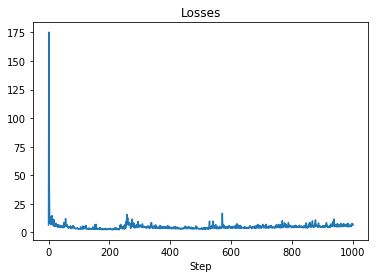

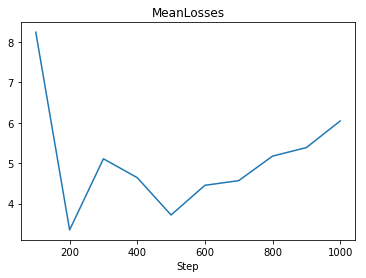

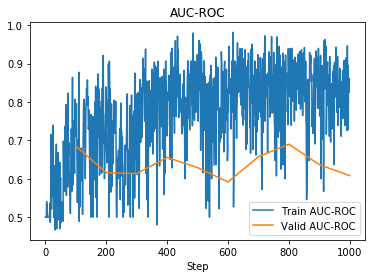

In [65]:
plot_results(losses[:], mean_losses, train_aucs[1:], valid_aucs, frequency)

In [43]:
print ('Valid AUC-ROC:',roc_auc_score(np.asarray(valid_lab).reshape(-1), np.asarray(valid_pred).reshape(-1)))

print ('Test AUC-ROC:',roc_auc_score(np.asarray(test_lab).reshape(-1), np.asarray(test_pred).reshape(-1)))

Valid AUC-ROC: 0.71243543787
Test AUC-ROC: 0.654818604741
